In [1]:
%matplotlib inline  

# Imports

In [2]:
import os
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import matplotlib.pylab as mpl
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
os.chdir("..")

In [4]:
from Prior_optimization.gpr import GPR
from Prior_optimization.mean_functions import Zero
from Prior_optimization.kernels import RBF
from Samplers.likelihoods import LikCategorical
from Prior_optimization.priors import OptimGaussianPrior
from Utilities.rand_generators import ClassificationGenerator
from Utilities import util
from Partial_stochasticity.Networks.classification_net_masked import ClassificationNetMasked
from Full_stochasticity.Networks.classification_net import ClassificationNet
from Full_stochasticity.Networks.mlp import MLP
from Prior_optimization.wasserstein_mapper import MapperWasserstein
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Partial_stochasticity.Networks.mlp_masked import MLPMasked as MLPMPS
from Partial_stochasticity.Networks.mlp_fs_stoch import StochMLP
from Partial_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization as GMLPRPS
from Full_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization as GMLPRFS
from Full_stochasticity.Networks.masked_mlp import MLPMasked as MLPMFS

In [5]:
util.set_seed(123)

In [6]:
mpl.rcParams['figure.dpi'] = 300

In [7]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# 1. Load `Banana` dataset

In [8]:
DATA_DIR = "./data/banana"
FIG_DIR = "./exp/2D_classification/"
util.ensure_dir(FIG_DIR)
OUT_DIR_PS = "./exp/2D_classification/partially_stochastic"
util.ensure_dir(OUT_DIR_PS)
OUT_DIR_FS = "./exp/2D_classification/fully_stochastic"
util.ensure_dir(OUT_DIR_FS)
OUT_DIR_PSS = "./exp/2D_classification/fully_stochastic_sparse"
util.ensure_dir(OUT_DIR_PSS)
OUT_DIR_FLS = "./exp/2D_classification/first_layer_stochastic"
util.ensure_dir(OUT_DIR_FLS)

In [9]:
# Load banana dataset
X = np.loadtxt(os.path.join(
    DATA_DIR, "banana_X_train"), delimiter=",").astype(np.float32)
y = np.loadtxt(os.path.join(
    DATA_DIR, "banana_Y_train"), delimiter=",").reshape([-1]).astype(np.int64)

In [10]:
# Setup directories
ckpt_dir_ps = os.path.join(OUT_DIR_PS, "ckpts")
util.ensure_dir(ckpt_dir_ps)
ckpt_dir_fs = os.path.join(OUT_DIR_FS, "ckpts")
util.ensure_dir(ckpt_dir_fs)
ckpt_dir_fls = os.path.join(OUT_DIR_FLS, "ckpts")
util.ensure_dir(ckpt_dir_fls)

# 2. Configure the MLP

In [11]:
input_dim = 2
output_dim = 2
hidden_dims = [100] * 2
activation_fn = "tanh"

# 3. Prior optimization

In [12]:
mapper_n_samples = 128         # The size of mini batch used in Wasserstein optimization
mapper_n_lipschitz_iters = 200 # The number of Lipschitz function iterations per prior iteration
mapper_n_prior_iters = 200     # The number of prior iterations
mapper_lipschitz_lr = 0.02     # The learning rate for the opimization of the Lipschitz function (inner loop)
mapper_prior_lr = 0.05         # The learning rate for the optimization of the prior (outer loop)

In [13]:
# Configurations for the prior optimization
D = 3                                                          # The factorization depth
mapper_batch_size = 256     
num_iters_ps = 5000                                    
prior_opt_configurations = {
    "n_data": mapper_batch_size,                                # The batch size 
    "num_iters": num_iters_ps,                                  # The number of iterations of the prior optimization
    "output_dim": 2,                                            # The dimension of the output
    "lambd": (torch.tensor([0.25, 0.5, 0.75])/D).to(device),          # The regularization parameters for the layers
    "n_samples": 100,                                           # The number of function samples
    "lr": 5e-2,                                                 # The learning rate for the optimizer
    "print_every": 100,                                         # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                      # After how many epochs a checkpoint should be saved
}

In [14]:
sampler_batch_size = 32
sampling_configs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

In [15]:
variance = 1
lengthscale = 32
# Set up of the networks 
# Initialize BNN Priors
opt_bnn_sp = FactorizedGaussianMLPReparameterization(input_dim=input_dim, output_dim=output_dim, D = D, 
            activation_fn=activation_fn, hidden_dims=hidden_dims, device = device)
opt_bnn_sp = opt_bnn_sp.to(device)

opt_bnn_fls = GMLPRPS(input_dim = input_dim, output_dim = output_dim, hidden_dims = hidden_dims, 
                                            activation_fn = activation_fn)
opt_bnn_fls = opt_bnn_fls.to(device)

opt_bnn_fs = GMLPRFS(input_dim = input_dim, output_dim = output_dim, hidden_dims = hidden_dims, 
                                            activation_fn = activation_fn)
opt_bnn_fs = opt_bnn_fs.to(device)

## 3.0.1 Optimize Sparse Prior

In [16]:
masks_list = []
# Initialize data loader for the mapper
data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
# Setup of the measurement set generator
# We draw measurement points from the training data
rand_generator = ClassificationGenerator(data_loader)

# Specify the target GP prior
X_, y_ = rand_generator.get(return_label=True)
kernel = RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double, device = device),
            variance=torch.tensor([variance], dtype=torch.double, device = device))
gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_, 2).double(),
                            kern=kernel, mean_function=Zero())

# Initialize the mapper
mapper = PriorOptimisationMapper(out_dir=OUT_DIR_PS, device=device, gp = gp, out_det=False).to(device)
        
# Start optimization
print("Start optimizing prior")
p_hist, loss_hist = mapper.optimize(opt_bnn_sp, rand_generator,**prior_opt_configurations)
path = os.path.join(OUT_DIR_PS, "loss_values.log")
if not os.path.isfile(OUT_DIR_PS):
    os.makedirs(OUT_DIR_PS, exist_ok=True)
np.savetxt(path, loss_hist, fmt='%.6e')
path = os.path.join(OUT_DIR_PS, "pruned_values.log")
if not os.path.isfile(OUT_DIR_PS):
    os.makedirs(OUT_DIR_PS, exist_ok=True)
np.savetxt(path, p_hist, fmt='%.6e')
with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sp.get_det_masks(), f)

Start optimizing prior
>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 38.4228 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 12.7802 Number of pruned stochastic weights: 4
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 11.3933 Number of pruned stochastic weights: 11
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 4.2021 Number of pruned stochastic weights: 18
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 9.2381 Number of pruned stochastic weights: 26
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 14.0271 Number of pruned stochastic weights: 33
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 16.2775 Number of pruned stochastic weights: 45
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 14.9444 Number of pruned stochastic weights: 63
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 8.2938 Number of pruned stochastic weig

## 3.0.1 Optimize Fully Stochastic Prior

In [17]:
# Initialize data loader for the mapper
data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
# Setup the measurement set generator
# We draw measurement points from the training data
rand_generator = ClassificationGenerator(data_loader)

# Specify the target GP prior
X_, y_ = rand_generator.get(return_label=True)
kernel = RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double),
            variance=torch.tensor([variance], dtype=torch.double))
gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_).double(),
                            kern=kernel, mean_function=Zero())
        
# Initialize the mapper
mapper = MapperWasserstein(gp, opt_bnn_fs, rand_generator, out_dir=OUT_DIR_FS,
                                   output_dim=output_dim,
                                   n_data=mapper_batch_size,
                                   wasserstein_steps=(0, mapper_n_lipschitz_iters),
                                   wasserstein_lr=mapper_lipschitz_lr,
                                   wasserstein_thres=0.1,
                                   n_gpu=n_gpu)
        
# Start optimization
print("Start optimizing prior")
w_hist = mapper.optimize(num_iters=mapper_n_prior_iters, n_samples=mapper_n_samples,
                        lr=mapper_prior_lr, print_every=5,
                        save_ckpt_every=20, debug=True)
path = os.path.join(OUT_DIR_FS, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')

Start optimizing prior
>>> Iteration #   1: Wasserstein Dist 25.5575
>>> Iteration #   5: Wasserstein Dist 3.4695
>>> Iteration #  10: Wasserstein Dist 5.7174
>>> Iteration #  15: Wasserstein Dist 0.1936
>>> Iteration #  20: Wasserstein Dist 11.5564
>>> Iteration #  25: Wasserstein Dist 3.7118
>>> Iteration #  30: Wasserstein Dist -1.7612
>>> Iteration #  35: Wasserstein Dist -1.5841
>>> Iteration #  40: Wasserstein Dist -2.6004
>>> Iteration #  45: Wasserstein Dist 0.6761
>>> Iteration #  50: Wasserstein Dist -2.0691
>>> Iteration #  55: Wasserstein Dist -0.9342
>>> Iteration #  60: Wasserstein Dist -0.3026
>>> Iteration #  65: Wasserstein Dist 2.6096
>>> Iteration #  70: Wasserstein Dist -0.5032
>>> Iteration #  75: Wasserstein Dist -0.0389
>>> Iteration #  80: Wasserstein Dist -0.5868
>>> Iteration #  85: Wasserstein Dist -2.2173
>>> Iteration #  90: Wasserstein Dist 3.0938
>>> Iteration #  95: Wasserstein Dist 4.9124
>>> Iteration # 100: Wasserstein Dist -1.1427
>>> Iteration # 105

## 3.0.2 Optimize Prior With Stochasticity Only in the First Layer

In [18]:
# Initialize data loader for the mapper
data_loader = data_utils.DataLoader(
                            data_utils.TensorDataset(torch.from_numpy(X),
                                                     torch.from_numpy(y)),
                            batch_size=mapper_batch_size, shuffle=True)
        
# Setup the measurement set generator
# We draw measurement points from the training data
rand_generator = ClassificationGenerator(data_loader)

# Specify the target GP prior
X_, y_ = rand_generator.get(return_label=True)
kernel = RBF(
            input_dim,
            lengthscales=torch.tensor([lengthscale], dtype=torch.double),
            variance=torch.tensor([variance], dtype=torch.double))
gp = GPR(X_.reshape([mapper_batch_size, -1]).double(),
                            util.to_one_hot(y_).double(),
                            kern=kernel, mean_function=Zero())
        
# Initialize the mapper
mapper = MapperWasserstein(gp, opt_bnn_fls, rand_generator, out_dir=OUT_DIR_FLS,
                                   output_dim=output_dim,
                                   n_data=mapper_batch_size,
                                   wasserstein_steps=(0, mapper_n_lipschitz_iters),
                                   wasserstein_lr=mapper_lipschitz_lr,
                                   wasserstein_thres=0.1,
                                   n_gpu=n_gpu)
        
# Start optimization
print("Start optimizing prior")
w_hist = mapper.optimize(num_iters=mapper_n_prior_iters, n_samples=mapper_n_samples,
                        lr=mapper_prior_lr, print_every=5,
                        save_ckpt_every=20, debug=True)
path = os.path.join(OUT_DIR_FLS, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')

Start optimizing prior
>>> Iteration #   1: Wasserstein Dist 1688.7986
>>> Iteration #   5: Wasserstein Dist 88.9291
>>> Iteration #  10: Wasserstein Dist 26.7366
>>> Iteration #  15: Wasserstein Dist 10.5643
>>> Iteration #  20: Wasserstein Dist 6.6338
>>> Iteration #  25: Wasserstein Dist 4.7197
>>> Iteration #  30: Wasserstein Dist 7.4608
>>> Iteration #  35: Wasserstein Dist 5.8100
>>> Iteration #  40: Wasserstein Dist -0.1518
>>> Iteration #  45: Wasserstein Dist 13.3687
>>> Iteration #  50: Wasserstein Dist 0.8692
>>> Iteration #  55: Wasserstein Dist 7.0585
>>> Iteration #  60: Wasserstein Dist 3.9062
>>> Iteration #  65: Wasserstein Dist 0.3261
>>> Iteration #  70: Wasserstein Dist 4.5970
>>> Iteration #  75: Wasserstein Dist -0.3168
>>> Iteration #  80: Wasserstein Dist 7.8368
>>> Iteration #  85: Wasserstein Dist 0.0494
>>> Iteration #  90: Wasserstein Dist 5.0246
>>> Iteration #  95: Wasserstein Dist 0.6691
>>> Iteration # 100: Wasserstein Dist 5.1632
>>> Iteration # 105: Wa

## 3.1 Visualize Progression of the Prior Optimization

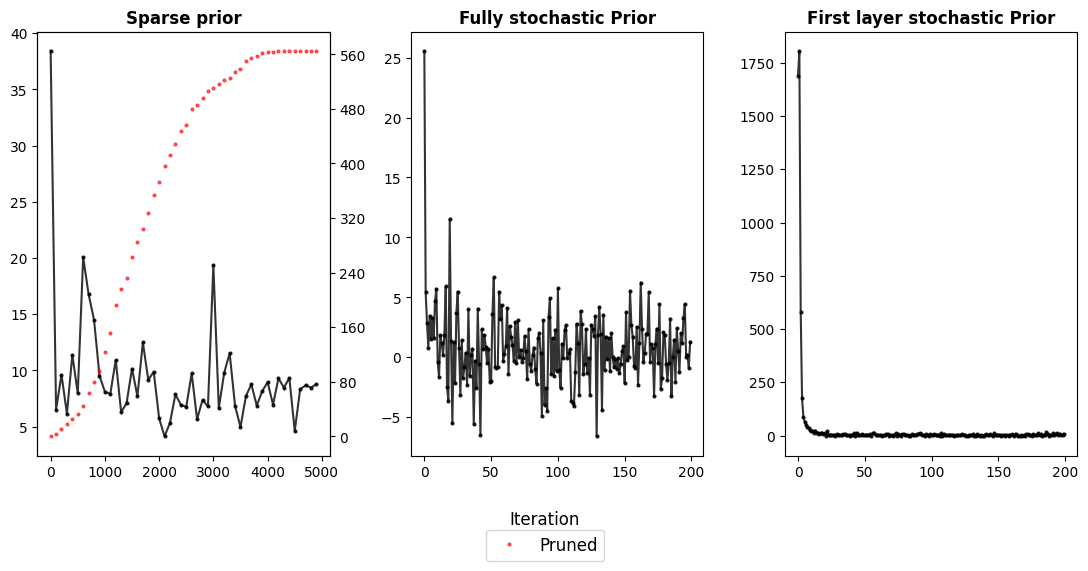

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(11, 5), sharex=False, dpi=100)

ebswdist_file = os.path.join(OUT_DIR_PS, "loss_values.log")
ebswdist_vals = np.loadtxt(ebswdist_file)
pruned_file = os.path.join(OUT_DIR_PS, "pruned_values.log")
pruned_vals = np.loadtxt(pruned_file)
indices_ps = np.arange(0, num_iters_ps)[::100]
indices_fs = np.arange(0, mapper_n_prior_iters)[::20]

# Plot loss on primary axis
h1 = axs[0].plot(indices_ps, ebswdist_vals[indices_ps], "-ok", ms=2, alpha=0.8, label="Loss")
axs[0].set_title("Sparse prior", fontsize=12, fontweight='bold')

# Plot pruned weights on secondary y-axis
ax2 = axs[0].twinx()
h2, = ax2.plot(indices_ps, pruned_vals[indices_ps], "ro", ms=2, alpha=0.6, label="Number of pruned weights")
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot fully stochastic next to it
fs_wdist_file = os.path.join(OUT_DIR_FS, "wsr_values.log")
fs_wdist_vals = np.loadtxt(fs_wdist_file)
        
axs[1].plot(fs_wdist_vals, "-ok", ms=2, alpha=0.8)
axs[1].set_title("Fully stochastic Prior", fontsize=12, fontweight='bold')

# Plot first layer stochastic next to it 
fls_wdist_file = os.path.join(OUT_DIR_FLS, "wsr_values.log")
fls_wdist_vals = np.loadtxt(fls_wdist_file)
        
axs[2].plot(fls_wdist_vals, "-ok", ms=2, alpha=0.8)
axs[2].set_title("First layer stochastic Prior", fontsize=12, fontweight='bold')

# Shared axis labels
fig.text(0.5, -0.05, "Iteration", ha="center", va="center", fontsize=12)

# Add legend outside the figure (bottom center)
fig.legend([h1, h2], ["Loss", "Pruned"], loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.15),fontsize=12)

plt.tight_layout()

fig_path = os.path.join(FIG_DIR, "prior_optimization")
plt.savefig(fig_path)
plt.show()

## 4. Posterior Inference

## 4.0.0 Sampling Configurations

In [22]:
# SGHMC Hyper-parameters
sampling_configs_ps = {
    "batch_size": 32,            # Mini-batch size
    "num_samples": 30,           # Total number of samples for each chain
    "n_discarded": 10,           # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,   # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,           # Thinning interval
    "lr": 0.01,                  # Step size
    "num_chains": 4,             # Number of chains
    "mdecay": 0.01,              # Momentum coefficient
    "print_every_n_samples": 5,  # After how many iterations an evaluation should be printed
    "lambd": 5e-8                # The lambda for encouraging sparsity in the deterministic weights
}

with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "rb") as f:
    weights_mask_sp, bias_mask_sp = pickle.load(f)


## 4.0.1 Training Deterministic Weights Before Sampling

In [23]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
likelihood = LikCategorical()
        
 # Load the optimized prior
ckpt_path = os.path.join(OUT_DIR_PS, "ckpts", "it-{}.ckpt".format(num_iters_ps))
print("Loading prior")
prior_ps = OptimGaussianPrior(ckpt_path)
checkpoint = torch.load(ckpt_path)
W_std_list = []
b_std_list = []
W_std_out = 1
b_std_out = 1
for key, value in checkpoint.items():
    if key == "out_b_standdev":
        b_std_out = value
    elif key == "out_W_standdev":
        W_std_out = value
    elif "W_std" in key:
        W_std_list.append(value)
    elif "b_std" in key:
        b_std_list.append(value)
        
# Initialize the Bayesian net
net = MLPMPS(input_dim, output_dim, hidden_dims, activation_fn, weights_mask_sp, bias_mask_sp, D = D, 
             prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, W_std_out = W_std_out, b_std_out = b_std_out,
                       task = "classification", device=device)
samples_dir = os.path.join(OUT_DIR_PS, "samples")
util.ensure_dir(samples_dir)
net_optim_spb = ClassificationNetMasked(net, likelihood, prior_ps, OUT_DIR_PS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
sampling_configs_psb = sampling_configs_ps
sampling_configs_psb["train_det"] = "before"
sampling_configs_psb["det_train_steps"] = 2000
net_optim_spb.sample_multi_chains(data_loader=data_loader, **sampling_configs_psb)
mean_preds, preds = net_optim_spb.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_spb.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_spb.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds_before.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Loading prior
Chain: 1
Samples #     5 : NLL = 0.16248 Acc = 0.9688 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.14025 Acc = 0.9062 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.08198 Acc = 1.0000 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.06540 Acc = 1.0000 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    25 : NLL = 0.12956 Acc = 0.9375 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.11882 Acc = 0.9688 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Chain: 2
Samples #    35 : NLL = 0.04051 Acc = 0.9688 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    40 : NLL = 0.08158 Acc = 0.9688 
 Pruned deterministic weights: 51 Pruned stochastic weights: 0
Samples #    45 : NLL = 0.06215 Acc = 1.0000 
 Pruned deterministic weights: 51 Pruned stochasti

120it [00:03, 35.04it/s]


## 4.0.2 Training Deterministic Weights During Sampling

In [24]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
net = MLPMPS(input_dim, output_dim, hidden_dims, activation_fn, weights_mask_sp, bias_mask_sp, D = D, 
             prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, W_std_out = W_std_out, b_std_out = b_std_out,
                       task = "classification", device=device)
# Initialize the Bayesian net
net_optim_spd = ClassificationNetMasked(net, likelihood, prior_ps, OUT_DIR_PS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
sampling_configs_psd = sampling_configs_ps
sampling_configs_psd["train_det"] = "during"
sampling_configs_psd["det_train_steps"] = 2000
net_optim_spd.sample_multi_chains(data_loader=data_loader, **sampling_configs_psd)
mean_preds, preds = net_optim_spd.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_spd.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_spd.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds_during.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Chain: 1
Samples #     5 : NLL = 0.08168 Acc = 0.9688 
 Pruned deterministic weights: 39 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.15180 Acc = 0.9688 
 Pruned deterministic weights: 48 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.13244 Acc = 0.9688 
 Pruned deterministic weights: 62 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.09763 Acc = 0.9688 
 Pruned deterministic weights: 86 Pruned stochastic weights: 0
Samples #    25 : NLL = 0.15137 Acc = 0.9375 
 Pruned deterministic weights: 110 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.14623 Acc = 0.9375 
 Pruned deterministic weights: 129 Pruned stochastic weights: 0
Chain: 2
Samples #    35 : NLL = 0.07035 Acc = 0.9688 
 Pruned deterministic weights: 238 Pruned stochastic weights: 0
Samples #    40 : NLL = 0.02845 Acc = 1.0000 
 Pruned deterministic weights: 244 Pruned stochastic weights: 0
Samples #    45 : NLL = 0.08467 Acc = 0.9688 
 Pruned deterministic weights: 253 Pruned stochastic weights

120it [00:03, 31.65it/s]


## 4.0.3 Training Deterministic Weights After Sampling

In [25]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
net = MLPMPS(input_dim, output_dim, hidden_dims, activation_fn, weights_mask_sp, bias_mask_sp, D = D, 
             prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, W_std_out = W_std_out, b_std_out = b_std_out,
                       task = "classification", device=device)
# Initialize the Bayesian net
net_optim_spa = ClassificationNetMasked(net, likelihood, prior_ps, OUT_DIR_PS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
sampling_configs_psa = sampling_configs_ps
sampling_configs_psa["train_det"] = "after"
sampling_configs_psa["det_train_steps"] = 2000
net_optim_spa.sample_multi_chains(data_loader=data_loader, **sampling_configs_psa)
mean_preds, preds = net_optim_spa.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_spa.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_spa.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds_after.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Chain: 1
Samples #     5 : NLL = 0.43964 Acc = 0.8750 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.45244 Acc = 0.8125 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.42388 Acc = 0.8438 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.40644 Acc = 0.8750 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    25 : NLL = 0.37011 Acc = 0.9062 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.48360 Acc = 0.7812 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Chain: 2
Samples #    35 : NLL = 0.45725 Acc = 0.8750 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    40 : NLL = 0.39614 Acc = 0.9375 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    45 : NLL = 0.49816 Acc = 0.8438 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples # 

120it [00:03, 32.84it/s]


## 4.0.4 Sparse BNN

In [26]:
sampler_batch_size = 32
sampling_configs_sp = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

In [27]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
net = MLPMFS(input_dim, output_dim, hidden_dims, activation_fn, weights_mask_sp, bias_mask_sp,
                       task = "classification", device=device) 

# Initialize the Bayesian net
samples_dir = os.path.join(OUT_DIR_PSS, "samples")
util.ensure_dir(samples_dir)
net_optim_fss = ClassificationNet(net, likelihood, prior_ps, OUT_DIR_PSS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
sampling_configs_psa = sampling_configs_ps
net_optim_fss.sample_multi_chains(data_loader=data_loader, **sampling_configs_sp)
mean_preds, preds = net_optim_fss.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_fss.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_fss.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Chain: 0
Samples #     5 : NLL = 0.12398 Acc = 0.9375 
Samples #    10 : NLL = 0.13479 Acc = 1.0000 
Samples #    15 : NLL = 0.09050 Acc = 1.0000 
Samples #    20 : NLL = 0.24751 Acc = 0.8750 
Samples #    25 : NLL = 0.16608 Acc = 0.9375 
Samples #    30 : NLL = 0.18180 Acc = 0.9688 
Chain: 1
Samples #    35 : NLL = 0.06344 Acc = 1.0000 
Samples #    40 : NLL = 0.18254 Acc = 0.9375 
Samples #    45 : NLL = 0.17560 Acc = 0.9688 
Samples #    50 : NLL = 0.17350 Acc = 0.9375 
Samples #    55 : NLL = 0.19018 Acc = 0.9375 
Samples #    60 : NLL = 0.19971 Acc = 0.9375 
Chain: 2
Samples #    65 : NLL = 0.12817 Acc = 0.9375 
Samples #    70 : NLL = 0.26666 Acc = 0.8438 
Samples #    75 : NLL = 0.24583 Acc = 0.8750 
Samples #    80 : NLL = 0.14417 Acc = 1.0000 
Samples #    85 : NLL = 0.16768 Acc = 0.9688 
Samples #    90 : NLL = 0.17281 Acc = 0.9688 
Chain: 3
Samples #    95 : NLL = 0.08857 Acc = 1.0000 
Samples #   100 : NLL = 0.22463 Acc = 0.8750 
Samples #   105 : NLL = 0.08761 Acc = 1.0000

120it [00:02, 54.85it/s]


## 4.0.5 Full BNN

In [28]:
sampler_batch_size = 32
sampling_configs_fs = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

In [29]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
        
# Setup the likelihood
net = MLP(input_dim, output_dim, hidden_dims, activation_fn, task = "classification") 

ckpt_path = os.path.join(OUT_DIR_FS, "ckpts", "it-{}.ckpt".format(mapper_n_prior_iters))
print("Loading prior")
prior_fs = OptimGaussianPrior(ckpt_path)

# Initialize the Bayesian net
samples_dir = os.path.join(OUT_DIR_FS, "samples")
util.ensure_dir(samples_dir)
net_optim_fs = ClassificationNet(net, likelihood, prior_fs, OUT_DIR_FS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
net_optim_fs.sample_multi_chains(data_loader=data_loader, **sampling_configs_fs)
mean_preds, preds = net_optim_fs.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_fs.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_fs.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Loading prior
Chain: 0
Samples #     5 : NLL = 0.66084 Acc = 0.6875 
Samples #    10 : NLL = 0.68442 Acc = 0.6250 
Samples #    15 : NLL = 0.68223 Acc = 0.5938 
Samples #    20 : NLL = 0.63718 Acc = 0.7500 
Samples #    25 : NLL = 0.64247 Acc = 0.7188 
Samples #    30 : NLL = 0.66751 Acc = 0.5938 
Chain: 1
Samples #    35 : NLL = 0.64072 Acc = 0.7188 
Samples #    40 : NLL = 0.65098 Acc = 0.5938 
Samples #    45 : NLL = 0.64940 Acc = 0.6250 
Samples #    50 : NLL = 0.66739 Acc = 0.5625 
Samples #    55 : NLL = 0.64809 Acc = 0.6875 
Samples #    60 : NLL = 0.63508 Acc = 0.7500 
Chain: 2
Samples #    65 : NLL = 0.67750 Acc = 0.5625 
Samples #    70 : NLL = 0.68176 Acc = 0.4688 
Samples #    75 : NLL = 0.69218 Acc = 0.4375 
Samples #    80 : NLL = 0.67528 Acc = 0.5625 
Samples #    85 : NLL = 0.68528 Acc = 0.5312 
Samples #    90 : NLL = 0.70453 Acc = 0.5312 
Chain: 3
Samples #    95 : NLL = 0.67353 Acc = 0.5625 
Samples #   100 : NLL = 0.68951 Acc = 0.5938 
Samples #   105 : NLL = 0.6707

120it [00:01, 114.53it/s]


## 4.0.6 Stochasticity Only in the First Layer

In [30]:
sampler_batch_size = 32
sampling_configs_fls = {
    "batch_size": sampler_batch_size, # Mini-batch size
    "num_samples": 40,                # Total number of samples for each chain 
    "n_discarded": 10,                # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 200,         # Number of burn-in steps
    "keep_every": 200,                # Thinning interval
    "lr": 1e-2,                       # Step size
    "num_chains": 4,                  # Number of chains
    "mdecay": 1e-2,                   # Momentum coefficient
    "print_every_n_samples": 5
}

In [31]:
# Set up the dataloader
data_loader = data_utils.DataLoader(
                    data_utils.TensorDataset(torch.from_numpy(X), torch.from_numpy(y)),
                    batch_size=sampler_batch_size, shuffle=True)
samples_dir = os.path.join(OUT_DIR_FLS, "samples")
util.ensure_dir(samples_dir)
# Setup the likelihood
net = StochMLP(input_dim, output_dim, hidden_dims, activation_fn, task = "classification") 
# Initialize the Bayesian net
net_optim_fls = ClassificationNetMasked(net, likelihood, prior_ps, OUT_DIR_PS, n_gpu=n_gpu)
        
# Start sampling using SGHMC sampler
net_optim_fls.sample_multi_chains(data_loader=data_loader, **sampling_configs_fls)
mean_preds, preds = net_optim_fls.evaluate(data_loader, True, True)

# Make predictions using the posterior
preds = []
pred_means = []
targets = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader):
        pred_mean, pred = net_optim_fls.predict(
                    data, return_individual_predictions=True,
                    num_samples=40)

        pred_means.append(pred_mean)
        preds.append(pred)
        targets.append(target)

pred_means = torch.cat(pred_means, dim=0).cpu().numpy()
preds = torch.cat(preds, dim=1).cpu().numpy()
targets = torch.cat(targets, dim=0).cpu().numpy()
x_grid = np.linspace(-3, 3, 40)
xx, yy = np.meshgrid(x_grid, x_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T

p, _ = net_optim_fls.predict(torch.from_numpy(Xplot).float(), True, True)
p = p.cpu().numpy()
        
# Save the predictions to file
data = { "xx": xx, "yy": yy, "X": X, "y": y, "p": p}
with open(os.path.join(samples_dir, "preds.pickle"), 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


Chain: 1
Samples #     5 : NLL = 0.16991 Acc = 0.9062 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    10 : NLL = 0.11406 Acc = 1.0000 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    15 : NLL = 0.10485 Acc = 1.0000 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    20 : NLL = 0.09368 Acc = 1.0000 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    25 : NLL = 0.15165 Acc = 0.9688 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    30 : NLL = 0.05433 Acc = 1.0000 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Chain: 2
Samples #    35 : NLL = 0.27575 Acc = 0.8750 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    40 : NLL = 0.07805 Acc = 0.9688 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples #    45 : NLL = 0.18876 Acc = 0.9375 
 Pruned deterministic weights: 0 Pruned stochastic weights: 0
Samples # 

124it [00:01, 119.22it/s]


## 4.1 Visualize the predictive posterior

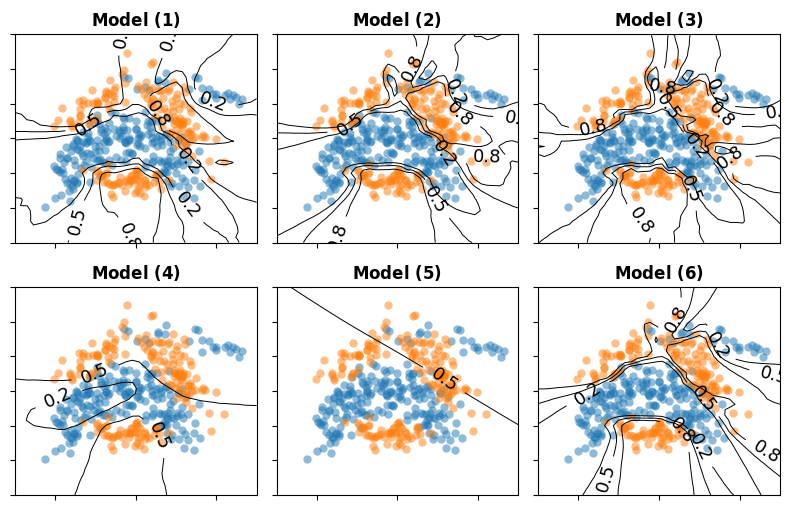

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=3, tight_layout=False,
                        figsize=(8, 5.2), sharex=True, sharey=True, dpi=100)

for i in range (2):
    for j in range(3):
        if i == 0 and j == 0:
            data_file = os.path.join(OUT_DIR_PSS, "samples", "preds.pickle")
            title = r"Model $\mathbf{(1)}$"
        elif i == 0 and j == 1:
            data_file = os.path.join(OUT_DIR_PS, "samples", "preds_before.pickle")
            title = r"Model $\mathbf{(2)}$"
        elif i == 0 and j == 2:
            data_file = os.path.join(OUT_DIR_PS, "samples", "preds_during.pickle")
            title = r"Model $\mathbf{(3)}$"
        elif i == 1 and j == 0:
            data_file = os.path.join(OUT_DIR_PS, "samples", "preds_after.pickle")
            title = r"Model $\mathbf{(4)}$"
        elif i == 1 and j == 1:
            data_file = os.path.join(OUT_DIR_FS, "samples", "preds.pickle")
            title = r"Model $\mathbf{(5)}$"
        elif i == 1 and j == 2:
            data_file = os.path.join(OUT_DIR_FLS, "samples", "preds.pickle")
            title = r"Model $\mathbf{(6)}$"

        with open(data_file, "rb") as f:
            data = pickle.load(f)
        
        X = data['X']
        y = data['y']
        p = data['p']
        xx = data['xx']
        yy = data['yy']

        mask = y.reshape([-1, 1])[:, 0] == 1
        Xplot = np.vstack((xx.flatten(), yy.flatten())).T
        
        ax[i, j].plot(X[mask, 0], X[mask, 1], "oC0", mew=0, alpha=0.5, ms=6)
        ax[i, j].plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], "oC1", mew=0, alpha=0.5, ms=6)
        CS = ax[i, j].contour(
            xx,
            yy,
            p[:, 0].reshape(*xx.shape),
            [0.2, 0.5, 0.8],
            colors="k",
            linewidths=0.7,
            zorder=100,
        )
        ax[i, j].clabel(CS, inline=1, fontsize=13, fmt='%1.1f')
        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_title(title, fontsize = 12, fontweight = 'bold')
            
plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "predictive_posterior")
plt.savefig(fig_path)
plt.show()